In [2]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from tqdm import tqdm
import os
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def load_data(data_dir="../MNIST_dataset"):
    trainset = datasets.MNIST(
        root=data_dir, train=True, transform=ToTensor(), download=True)

    testset = datasets.MNIST(
        root=data_dir, train=False, transform=ToTensor(), download=True)

    return trainset, testset


trainset, testset = load_data()

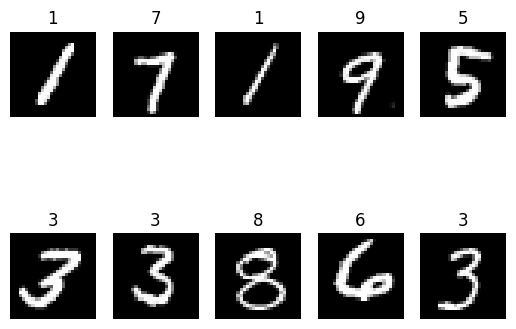

In [5]:
fig = plt.figure()
cols, rows = 5, 2

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1, 1)).item()
    img, label = trainset[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')

plt.show()

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length) -> None:
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.shape[0], self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.shape[0], self.hidden_size).to(device)
        out, _ = self.rnn(x, (h0, c0))
        out = out[:, -1,: ]
        out = self.fc(out)
        return out

In [20]:
test_abs = int(len(trainset) * 0.8)
train_subset, val_subset = random_split(
    trainset, [test_abs, len(trainset) - test_abs]
)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)

In [21]:
model = RNN(sequence_length=28, input_size=28, hidden_size=256, num_layers=2, num_classes=10).to(device)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
writer = SummaryWriter(f'runs/MNIST/logs')

In [24]:
epochs = 2
train_step = 0
val_step = 0

for epoch in range(epochs):
    # train
    running_loss = 0.0
    for data in tqdm(train_loader, desc="Training"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        out = model(inputs.squeeze(1))
        loss = criterion(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predictions = out.max(1)
        num_correct = (predictions == labels).sum().item()
        running_train_acc = num_correct / float(inputs.shape[0])

        writer.add_histogram('fc', model.fc.weight)
        writer.add_scalar('Training loss', loss / (inputs.shape[0]), global_step=train_step)
        writer.add_scalar('Training accuracy', running_train_acc, global_step=train_step)
        train_step += 1

    print(f'Epoch: {epoch + 1} | Loss: {running_loss / len(train_loader)}')
    

    # validation
    total = 0
    correct = 0
    running_loss = 0.0
    for data in tqdm(val_loader, desc="Validation"):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs.squeeze(1))
            loss = criterion(out, labels)
            _, predicted = torch.max(out.data, dim=1)
            total += labels.shape[0]
            correct += (labels == predicted).sum().item()
            running_loss += loss.cpu().numpy()
    
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    
    print(f'Val loss: {val_loss} | Accuracy: {val_acc}')
    
    writer.add_scalar('Validation loss', val_loss, global_step=val_step)
    writer.add_scalar('Validation accuracy', val_acc, global_step=val_step)
    val_step += 1 

Training: 100%|██████████| 1500/1500 [01:56<00:00, 12.93it/s]


Epoch: 1 | Loss: 0.3920876051224768


Validation: 100%|██████████| 1500/1500 [00:33<00:00, 44.69it/s]


Val loss: 0.1306127949267005 | Accuracy: 0.9609791666666667


Training: 100%|██████████| 1500/1500 [01:54<00:00, 13.10it/s]


Epoch: 2 | Loss: 0.10119829447334633


Validation: 100%|██████████| 1500/1500 [00:32<00:00, 46.05it/s]

Val loss: 0.05839836493957167 | Accuracy: 0.9826041666666666


In [25]:
test_loader = DataLoader(testset, batch_size=100, shuffle=False)
with torch.no_grad():
    for data in tqdm(test_loader, desc="Testing"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs.squeeze(1))
        loss = criterion(out, labels)
        _, predicted = torch.max(out.data, dim=1)
        total += labels.shape[0]
        correct += (labels == predicted).sum().item()
        running_loss += loss.cpu().numpy()

print(f'Accuracy: {correct / total}')

Testing: 100%|██████████| 100/100 [00:05<00:00, 17.03it/s]

Accuracy: 0.982396551724138
